<a href="https://colab.research.google.com/github/beyza522/Azheimer-Classification/blob/main/CNN_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!unzip "/content/drive/MyDrive/Colab Notebooks/AugmentedAlzheimerDataset.zip"

In [ ]:
!unzip "/content/drive/MyDrive/Colab Notebooks/OriginalDataset.zip"

In [ ]:
!unzip "/content/drive/MyDrive/Colab Notebooks/Dataset.zip"

In [6]:
#Environment check
import os
import warnings
warnings.filterwarnings("ignore")

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import skimage.io
import os 
import tqdm
import glob
import tensorflow 

from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.color import grey2rgb

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPool2D, Conv2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.utils import to_categorical
from keras import optimizers
from tensorflow.keras.optimizers import Adam
from keras.applications.nasnet import NASNetLarge, NASNetMobile
from keras.callbacks import Callback,ModelCheckpoint,ReduceLROnPlateau
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
import keras.backend as K

#import tensorflow_addons as tfa
#from tensorflow.keras.metrics import Metric
#from tensorflow_addons.utils.types import AcceptableDTypes, FloatTensorLike
from typeguard import typechecked
from typing import Optional

# System libraries
from pathlib import Path
import os.path
from tensorflow.keras.layers import Conv2D, Flatten, MaxPooling2D, Dense, Dropout, GlobalAveragePooling2D

from tensorflow.keras.preprocessing.image import load_img, img_to_array
import skimage.io
from skimage.io import imread, imshow

In [11]:
data = "/content/AugmentedAlzheimerDataset"

In [12]:
image_dir = Path(data)

# Get filepaths and labels
filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg')) 

labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)

In [13]:
import PIL
from pathlib import Path
from PIL import UnidentifiedImageError
path = Path("/content/AugmentedAlzheimerDataset").rglob("*.jpg")
for img_p in path:
    try:
        img = PIL.Image.open(img_p)
    except PIL.UnidentifiedImageError:
            print(img_p)

In [14]:
image_df

,Filepath,Label
0,/content/AugmentedAlzheimerDataset/ModerateDem...,ModerateDemented
1,/content/AugmentedAlzheimerDataset/ModerateDem...,ModerateDemented
2,/content/AugmentedAlzheimerDataset/ModerateDem...,ModerateDemented
3,/content/AugmentedAlzheimerDataset/ModerateDem...,ModerateDemented
4,/content/AugmentedAlzheimerDataset/ModerateDem...,ModerateDemented
...,...,...
33979,/content/AugmentedAlzheimerDataset/NonDemented...,NonDemented
33980,/content/AugmentedAlzheimerDataset/NonDemented...,NonDemented
33981,/content/AugmentedAlzheimerDataset/NonDemented...,NonDemented
33982,/content/AugmentedAlzheimerDataset/NonDemented...,NonDemented


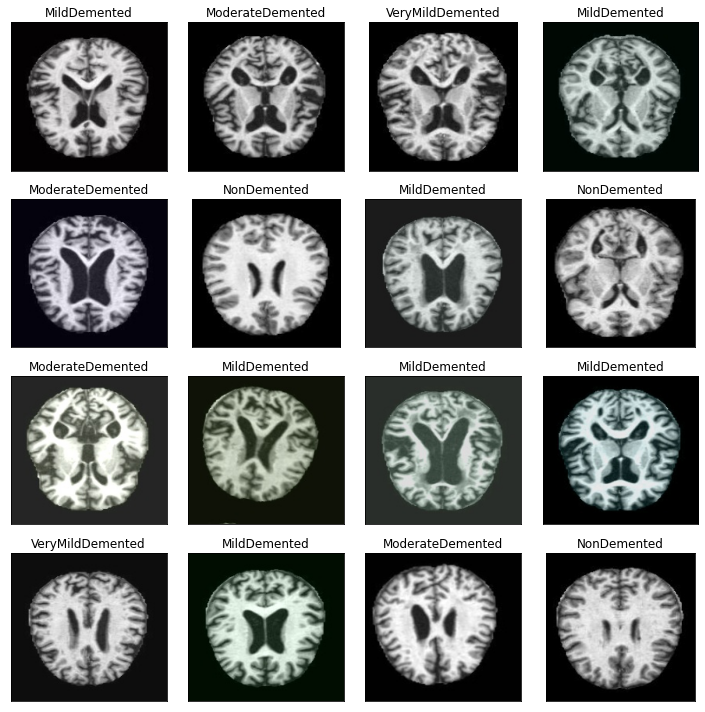

In [15]:
# Display 16 picture of the dataset with their labels
random_index = np.random.randint(0, len(image_df), 16)
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[random_index[i]]))
    ax.set_title(image_df.Label[random_index[i]])
plt.tight_layout()
plt.show()

In [16]:
#DATA AUGMENTATION

In [17]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split = 0.2)

valid_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split = 0.2)

test_datagen  = ImageDataGenerator(rescale = 1./255)

In [18]:
train_dataset  = train_datagen.flow_from_directory(directory = '/content/AugmentedAlzheimerDataset',
                                                   target_size = (224,224),
                                                   batch_size = 32,
                                                   class_mode = 'categorical',
                                                   subset = 'training')

valid_dataset = valid_datagen.flow_from_directory(directory = '/content/AugmentedAlzheimerDataset',
                                                  target_size = (224,224),
                                                  batch_size = 32,
                                                  class_mode = 'categorical',
                                                  subset = 'validation')

test_dataset  = test_datagen.flow_from_directory(directory = '/content/Dataset',
                                                 target_size = (224,224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')


Found 27188 images belonging to 4 classes.
Found 6796 images belonging to 4 classes.
Found 6400 images belonging to 4 classes.


In [20]:
model = tf.keras.models.Sequential([
    Conv2D(16, (3,3), activation = 'relu', input_shape = (224,224, 3)),
    MaxPooling2D(2,2),
    Conv2D(32, (3,3), activation = 'relu'),
    MaxPooling2D(2,2),
    Conv2D(32, (3,3), activation = 'relu'),
    MaxPooling2D(2,2),
    Conv2D(32, (3,3), activation = 'relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(512, activation = 'relu'),
    Dropout(0.2),
    Dense(4, activation = 'softmax')
])

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 32)        9248      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 32)       0

In [22]:
def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [23]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc'),
        f1_score,
]

In [24]:
filepath = '/content/drive/MyDrive/Colab Notebooks/best_weights.hdf5'

earlystopping = EarlyStopping(monitor = 'val_auc', 
                              mode = 'max' , 
                              patience = 15,
                              verbose = 1)

checkpoint    = ModelCheckpoint(filepath, 
                                monitor = 'val_auc', 
                                mode='max', 
                                save_best_only=True, 
                                verbose = 1)


callback_list = [earlystopping, checkpoint]

In [25]:
model.compile(loss = 'categorical_crossentropy', optimizer = tf.keras.optimizers.Adam(), metrics = METRICS)
history = model.fit(train_dataset,
    steps_per_epoch=len(train_dataset),
    validation_data=valid_dataset,
    validation_steps=len(valid_dataset),
    epochs=100,
    callbacks=callback_list,
    verbose = 1)

Epoch 1/100
850/850 [==============================] - ETA: 0s - loss: 0.8445 - accuracy: 0.8258 - precision: 0.7405 - recall: 0.4670 - auc: 0.8680 - f1_score: 0.5458
Epoch 1: val_auc improved from -inf to 0.93428, saving model to /content/drive/MyDrive/Colab Notebooks/best_weights.hdf5
850/850 [==============================] - 72s 75ms/step - loss: 0.8445 - accuracy: 0.8258 - precision: 0.7405 - recall: 0.4670 - auc: 0.8680 - f1_score: 0.5458 - val_loss: 0.6117 - val_accuracy: 0.8756 - val_precision: 0.8157 - val_recall: 0.6488 - val_auc: 0.9343 - val_f1_score: 0.7216
Epoch 2/100
849/850 [============================>.] - ETA: 0s - loss: 0.5142 - accuracy: 0.8925 - precision: 0.8209 - recall: 0.7288 - auc: 0.9523 - f1_score: 0.7711
Epoch 2: val_auc improved from 0.93428 to 0.96566, saving model to /content/drive/MyDrive/Colab Notebooks/best_weights.hdf5
850/850 [==============================] - 62s 72ms/step - loss: 0.5141 - accuracy: 0.8925 - precision: 0.8209 - recall: 0.7289 - au

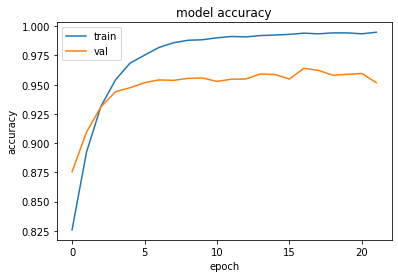

In [26]:
#Accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

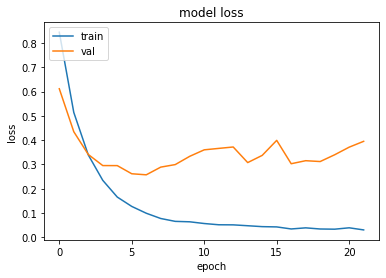

In [27]:
# loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

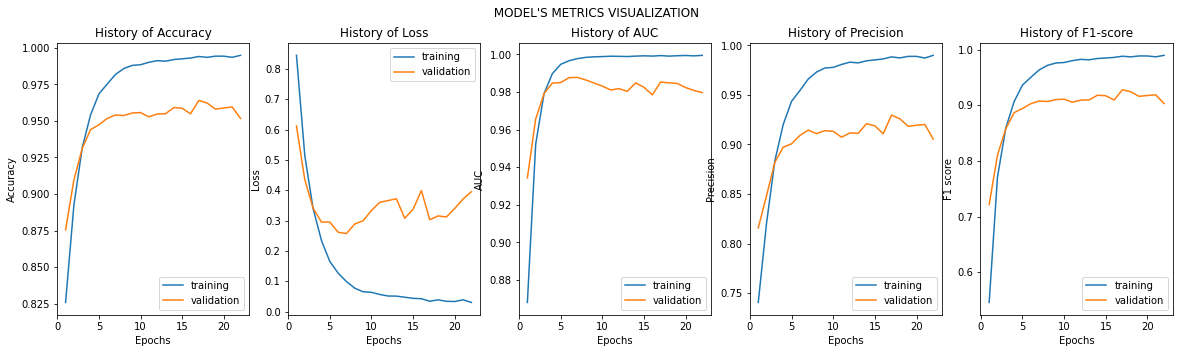

In [28]:
#%% PLOTTING RESULTS (Train vs Validation FOLDER 1)

def Train_Val_Plot(acc,val_acc,loss,val_loss,auc,val_auc,precision,val_precision,f1,val_f1):
    
    fig, (ax1, ax2,ax3,ax4,ax5) = plt.subplots(1,5, figsize= (20,5))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(['training', 'validation'])
    
    ax3.plot(range(1, len(auc) + 1), auc)
    ax3.plot(range(1, len(val_auc) + 1), val_auc)
    ax3.set_title('History of AUC')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('AUC')
    ax3.legend(['training', 'validation'])
    
    ax4.plot(range(1, len(precision) + 1), precision)
    ax4.plot(range(1, len(val_precision) + 1), val_precision)
    ax4.set_title('History of Precision')
    ax4.set_xlabel('Epochs')
    ax4.set_ylabel('Precision')
    ax4.legend(['training', 'validation'])
    
    ax5.plot(range(1, len(f1) + 1), f1)
    ax5.plot(range(1, len(val_f1) + 1), val_f1)
    ax5.set_title('History of F1-score')
    ax5.set_xlabel('Epochs')
    ax5.set_ylabel('F1 score')
    ax5.legend(['training', 'validation'])


    plt.show()
    

Train_Val_Plot(history.history['accuracy'],history.history['val_accuracy'],
               history.history['loss'],history.history['val_loss'],
               history.history['auc'],history.history['val_auc'],
               history.history['precision'],history.history['val_precision'],
               history.history['f1_score'],history.history['val_f1_score']
              )

In [29]:
score = model.evaluate(test_dataset)

200/200 [==============================] - 15s 76ms/step - loss: 0.0211 - accuracy: 0.9966 - precision: 0.9933 - recall: 0.9933 - auc: 0.9995 - f1_score: 0.9933


In [30]:
print("Accuracy = ", score[1])
print("Precision = ", score[2])
print("Recall = ", score[3])
print("AUC = ", score[4])
print("F1_score = ", score[5])

Accuracy =  0.9966406226158142
Precision =  0.9932812452316284
Recall =  0.9932812452316284
AUC =  0.9995148777961731
F1_score =  0.9932812452316284


1/1 [==============================] - 0s 218ms/step
100.0 % chances are there that the image is NonDemented


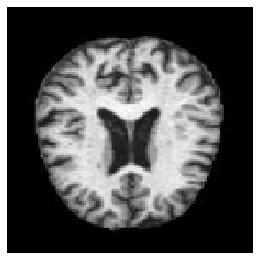

In [33]:
# Test Case 1: Non-Dementia

dic = test_dataset.class_indices
idc = {k:v for v, k in dic.items()}

img = load_img('/content/Dataset/NonDemented/non_10.jpg', target_size = (224,224,3))
img = img_to_array(img)
img = img/255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
#answer = model.predict_classes(img)
answer = np.argmax(model.predict(img), axis=1)
#probability = round(np.max(model.predict_proba(img)*100),2)
probability=round(np.max(model.predict_on_batch(img)*100),2)
print(probability, '% chances are there that the image is',idc[answer[0]])

1/1 [==============================] - 0s 22ms/step
100.0 % chances are there that the image is MildDemented


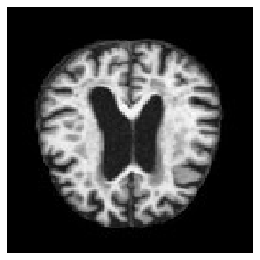

In [34]:
# Test Case 2: Mild Demented

dic = test_dataset.class_indices
idc = {k:v for v, k in dic.items()}

img = load_img('/content/Dataset/MildDemented/mild_102.jpg', target_size = (224,224,3))
img = img_to_array(img)
img = img/255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
answer = np.argmax(model.predict(img), axis=1)
probability=round(np.max(model.predict_on_batch(img)*100),2)
print(probability, '% chances are there that the image is',idc[answer[0]])

1/1 [==============================] - 0s 50ms/step
100.0 % chances are there that the image is ModerateDemented


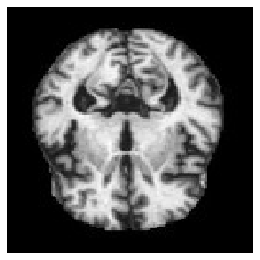

In [35]:
# Test Case 3: Moderate Demented

dic = test_dataset.class_indices
idc = {k:v for v, k in dic.items()}

img = load_img('/content/Dataset/ModerateDemented/moderate_18.jpg', target_size = (224,224,3))
img = img_to_array(img)
img = img/255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
answer = np.argmax(model.predict(img), axis=1)
probability=round(np.max(model.predict_on_batch(img)*100),2)
print(probability, '% chances are there that the image is',idc[answer[0]])

1/1 [==============================] - 0s 19ms/step
100.0 % chances are there that the image is VeryMildDemented


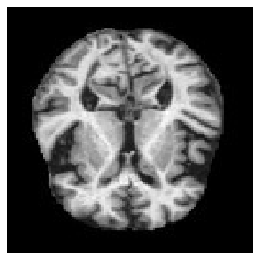

In [36]:
# Test Case 4: Very Mild Demented

dic = test_dataset.class_indices
idc = {k:v for v, k in dic.items()}

img = load_img('/content/Dataset/VeryMildDemented/verymild_1000.jpg', target_size = (224,224,3))
img = img_to_array(img)
img = img/255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
answer = np.argmax(model.predict(img), axis=1)
probability=round(np.max(model.predict_on_batch(img)*100),2)
print(probability, '% chances are there that the image is',idc[answer[0]])

In [37]:
# NON

dic = test_dataset.class_indices
idc = {k:v for v, k in dic.items()}

img_num = 0
correct_num = 0

for img_x in glob.glob("/content/OriginalDataset/NonDemented/*.jpg"):
  img_num += 1
  img = load_img(img_x, target_size = (224,224,3))
  img = img_to_array(img)
  img = img/255
  img = np.expand_dims(img,axis=0)
  answer = np.argmax(model.predict(img), axis=1)
  probability=round(np.max(model.predict_on_batch(img)*100),2)
  if(idc[answer[0]] == "NonDemented"):
    correct_num +=1
print("correct: "+str(correct_num))
print("images: "+str(img_num))
print("percentage: "+str(correct_num/img_num))

1/1 [==============================] - 0s 15ms/step
correct: 3189
images: 3200
percentage: 0.9965625


In [38]:
# MILD

dic = test_dataset.class_indices
idc = {k:v for v, k in dic.items()}

img_num = 0
correct_num = 0

for img_x in glob.glob("/content/OriginalDataset/MildDemented/*.jpg"):
  img_num += 1
  img = load_img(img_x, target_size = (224,224,3))
  img = img_to_array(img)
  img = img/255
  img = np.expand_dims(img,axis=0)
  answer = np.argmax(model.predict(img), axis=1)
  probability=round(np.max(model.predict_on_batch(img)*100),2)
  if(idc[answer[0]] == "MildDemented"):
    correct_num +=1
print("correct: "+str(correct_num))
print("images: "+str(img_num))
print("percentage: "+str(correct_num/img_num))

1/1 [==============================] - 0s 16ms/step
correct: 895
images: 896
percentage: 0.9988839285714286


In [39]:
# MODERATE

dic = test_dataset.class_indices
idc = {k:v for v, k in dic.items()}

img_num = 0
correct_num = 0

for img_x in glob.glob("/content/OriginalDataset/ModerateDemented/*.jpg"):
  img_num += 1
  img = load_img(img_x, target_size = (224,224,3))
  img = img_to_array(img)
  img = img/255
  img = np.expand_dims(img,axis=0)
  answer = np.argmax(model.predict(img), axis=1)
  probability=round(np.max(model.predict_on_batch(img)*100),2)
  if(idc[answer[0]] == "ModerateDemented"):
    correct_num +=1
print("correct: "+str(correct_num))
print("images: "+str(img_num))
print("percentage: "+str(correct_num/img_num))

1/1 [==============================] - 0s 16ms/step
correct: 64
images: 64
percentage: 1.0


In [40]:
# VERY MILD

dic = test_dataset.class_indices
idc = {k:v for v, k in dic.items()}

img_num = 0
correct_num = 0

for img_x in glob.glob("/content/OriginalDataset/VeryMildDemented/*.jpg"):
  img_num += 1
  img = load_img(img_x, target_size = (224,224,3))
  img = img_to_array(img)
  img = img/255
  img = np.expand_dims(img,axis=0)
  answer = np.argmax(model.predict(img), axis=1)
  probability=round(np.max(model.predict_on_batch(img)*100),2)
  if(idc[answer[0]] == "VeryMildDemented"):
    correct_num +=1
print("correct: "+str(correct_num))
print("images: "+str(img_num))
print("percentage: "+str(correct_num/img_num))

1/1 [==============================] - 0s 16ms/step
correct: 2201
images: 2240
percentage: 0.9825892857142857
